In [2]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

I0000 00:00:1703136330.237352  138971 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [167]:
# set basic parameters and subdirectory
part_n = 700
e_part_r = 0.8
e_mean = 0
ei_std_s = [4, 4]
waiting_time = 300
interval_len = waiting_time + 2000
freq = 0
seed = 1701297462#round(time.time())
# generate and save parameters for simulation
key = jrandom.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 1
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std, jnp.array([[0]]),
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = 1
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
ext_unscaled_std = jnp.asarray([[1.]])
ext_connectivity_n = 1
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, ext_unscaled_std,
                                                         ext_connectivity_n,
                                                         key)

phase_s = jnp.full((1,1), 0)
phase_n = 1
# [phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)

amp_s = jnp.expand_dims(jnp.asarray([0, 0.4]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 1
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
window_len_s = jnp.asarray([10, 20, 40, 80, 160, 320]) # used length = 1000
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

In [168]:
h_traj = traj_initializer(init_condition_s[0], jnp.array([0,interval_len]), resolution)
h_traj0 = rk4_ode_solver(
      lambda position:
      almlin_velocity_fct(connectivity_s[0], position),
      lambda time:
      sin_ext_input_fct(
        wave_s[0], ext_connectivity_s[0], phase_s[0],
        labeled_time_interval_s, time),
      h_traj,
      0, resolution)
h_traj1 = rk4_ode_solver(
      lambda position:
      almlin_velocity_fct(connectivity_s[0], position),
      lambda time:
      sin_ext_input_fct(
        wave_s[1], ext_connectivity_s[0], phase_s[0],
        labeled_time_interval_s, time),
      h_traj,
      0, resolution)
cov0 = matched_correlation_fct(h_traj0, h_traj0, 
                               jnp.mean(h_traj0, axis = 1), jnp.mean(h_traj0, axis = 1))
cov1 = matched_correlation_fct(h_traj1, h_traj1, 
                               jnp.mean(h_traj1, axis = 1), jnp.mean(h_traj1, axis = 1))
cov11 = matched_correlation_fct(h_traj1, h_traj1, 
                                0.4*ext_connectivity_s[0,:,0], 0.4*ext_connectivity_s[0,:,0])

In [205]:
jnp.corrcoef(jnp.mean(h_traj1, axis = 1) - 0.4*ext_connectivity_s[0,:,0], 0.4*ext_connectivity_s[0,:,0])

Array([[0.99999994, 0.04326068],
       [0.04326068, 1.        ]], dtype=float32)

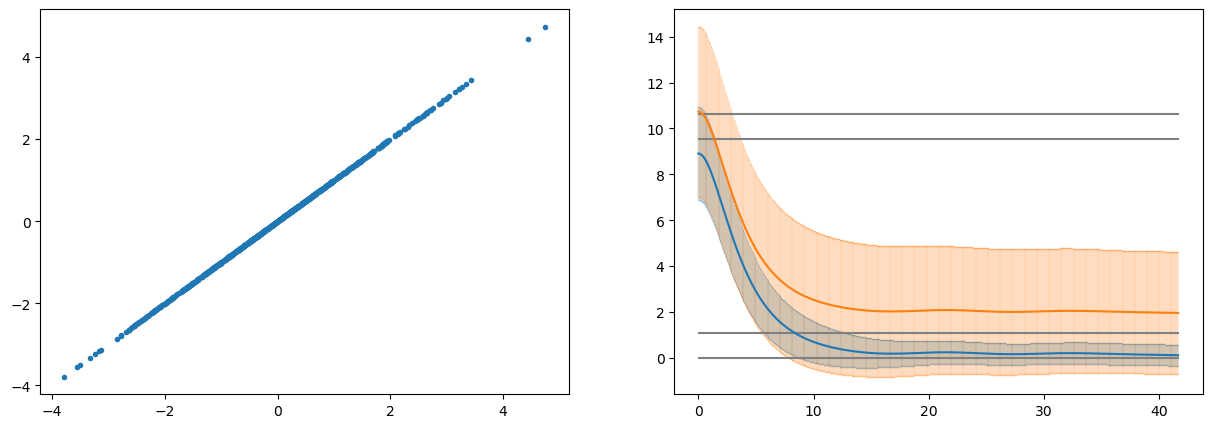

In [206]:
[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)
subfig_s[0,0].plot(jnp.mean(h_traj1, axis = 1) - 0.4*ext_connectivity_s[0,:,0],
         (connectivity_s[0]@jnp.mean(jnp.tanh(h_traj1), axis = 1, keepdims=True)).flatten(), linestyle ='', marker='.')
num=1000
# plt.errorbar(jnp.arange(num)/24,jnp.mean(cov0[:,:num], axis = 0), yerr = jnp.std(cov0[:,:num], axis = 0), elinewidth=0.1,capsize=0.1)
plt.errorbar(jnp.arange(num)/24,jnp.mean(cov1[:,:num], axis = 0), yerr = jnp.std(cov1[:,:num], axis = 0), elinewidth=0.1,capsize=0.1)
plt.errorbar(jnp.arange(num)/24,jnp.mean(cov11[:,:num], axis = 0), yerr = jnp.std(cov11[:,:num], axis = 0), elinewidth=0.1,capsize=0.1)
plt.hlines([10.618476, 10.618476 -1.091, 1.091, 0],0,num/24, color = 'gray')

In [207]:
print(jnp.var(jnp.mean(h_traj0, axis = 1)), jnp.var(jnp.mean(h_traj1, axis = 1)))
print(
jnp.var(jnp.mean(h_traj1, axis = 1) - 0.4*ext_connectivity_s[0,:,0]),
jnp.var((connectivity_s[0]@jnp.mean(jnp.tanh(h_traj1), axis = 1, keepdims=True)).flatten()),
jnp.var(jnp.std(jnp.mean(jnp.tanh(h_traj1),axis = 1)) * 4 *jrandom.normal(jrandom.PRNGKey(123),(part_n,))))
print(jnp.var(jnp.mean(jnp.tanh(h_traj1),axis = 1)) * 4**2)

0.040685497 2.0351424
1.8229023 1.8243517 1.8327188
1.7693211


predictions

In [3]:
# generic numerical function helpers
def num_primitive_fct(num_function, baseline_idx, iv_resolution, axis =-1):
  sum_left = jnp.cumsum(num_function, axis = axis) / iv_resolution
  sum_right = jnp.cumsum(-num_function[..., ::-1], axis = axis)[..., ::-1] / iv_resolution
  mean_sum = (sum_left + sum_right) / 2
  return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def num_integral_fct(num_function, iv_resolution, axis =-1):
  sum_left = jnp.sum(num_function[..., :-1], axis = axis) / iv_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = axis) / iv_resolution
  return((sum_left + sum_right) / 2)

def mirror(traj, transformation = lambda iv:iv):
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), traj], axis = -1))

def better_searchsorted(array, value, axis=None, keepdims=False):
  return(jnp.argmax((array >= value) & (jnp.roll(array, 1, axis = axis) < value), axis=axis, keepdims=keepdims))



def potential_s_fct(m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh = "out", 
                    num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  zero_iv_idx = jnp.searchsorted(iv_s, 0)
  tanh_pri_s = num_primitive_fct(jnp.tanh(iv_s), zero_iv_idx, num_fct_resolution)
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  def tanh_pri_fct(iv):
    return(jnp.interp(iv, iv_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))
  # potential 1
  potential_1_s = -(m_acov_s ** 2 / 2)
  # potential 2
  if g_tanh == "out":
    factor_out = unscaled_std ** 2
    factor_in = 1
  elif g_tanh == "in":
    factor_out = 1 / unscaled_std ** 2
    factor_in = unscaled_std
  m_var_s = jnp.expand_dims(m_var_s, (1, 2, 3))
  m_acov_s = jnp.expand_dims(m_acov_s, (2, 3))
  potential_2_s = num_integral_fct(
    num_integral_fct(
      tanh_pri_fct(factor_in * (
        jnp.sqrt(m_var_s - m_acov_s) * jnp.expand_dims(iv_s, (0, 1, 2))
        + jnp.sqrt(m_acov_s  + ext_unscaled_std ** 2) * jnp.expand_dims(iv_s, (0, 1, 3))))
      * sta_gau_fct(iv_s), num_fct_resolution) ** 2
    * sta_gau_fct(iv_s), num_fct_resolution) * factor_out
  potential_s = potential_1_s + potential_2_s
  return(potential_s)

def stable_m_var_fct(unscaled_std, ext_unscaled_std, g_tanh = "out", 
                     init_search_window = jnp.array([0,100]), search_resolution = 20, 
                     search_precision = 0.001, m_acov_step_n = 20,
                     num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  zero_iv_idx = jnp.searchsorted(iv_s, 0)
  tanh_pri_s = num_primitive_fct(jnp.tanh(iv_s), zero_iv_idx, num_fct_resolution)
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2 * jnp.pi))
  def tanh_pri_fct(iv):
    return(jnp.interp(iv, iv_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))
  value_precision = jnp.min(jnp.abs(sta_gau_fct(iv_s)))
  # while
  search_window = init_search_window
  while (search_window[1] - search_window[0]) > jnp.maximum(search_precision,
                                                            search_window[0] * search_precision):
    m_var_s = (search_window[0] 
               + jnp.arange(search_resolution) / (search_resolution + 1) * (search_window[1] - search_window[0]))
    if g_tanh == "out":
      factor_out = unscaled_std ** 2
      factor_in = 1
    elif g_tanh == "in":
      factor_out = 1 / unscaled_std ** 2
      factor_in = unscaled_std
    init_potential_s = (
      - (m_var_s ** 2 / 2)
      + num_integral_fct(
        tanh_pri_fct(factor_in * (
          jnp.sqrt(jnp.expand_dims(m_var_s, 1) + ext_unscaled_std ** 2) * jnp.expand_dims(iv_s, 0))) ** 2
        * sta_gau_fct(iv_s), num_fct_resolution) * factor_out)
    # find peak potentials
    if ext_unscaled_std == 0:
      peak_potential_s = num_integral_fct(
        tanh_pri_fct(factor_in * jnp.sqrt(jnp.expand_dims(m_var_s, 1)) * jnp.expand_dims(iv_s, 0))
        * sta_gau_fct(iv_s), num_fct_resolution) ** 2 * factor_out
      coarse_range_s = 1
      fine_peak_s = jnp.full((search_resolution, ), 0)
    else:
      coarse_m_acov_s = jnp.arange(m_acov_step_n) / m_acov_step_n * jnp.expand_dims(m_var_s, 1)
      coarse_potential_s = potential_s_fct(coarse_m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh, 
                                           num_fct_domain, num_fct_resolution)
      coarse_range_s = jnp.max(coarse_potential_s, axis = 1) - jnp.min(coarse_potential_s, axis = 1)
      coarse_potential_s = ((coarse_potential_s - jnp.min(coarse_potential_s, axis = 1, keepdims = True))
                            / jnp.expand_dims(coarse_range_s, 1))
      coarse_force_s = -jnp.gradient(coarse_potential_s, axis = 1)
      coarse_peak_idx_s = better_searchsorted(coarse_force_s, 0, axis = 1)
      fine_m_acov_s = (jnp.expand_dims(coarse_m_acov_s[jnp.arange(search_resolution),
                                                       jnp.maximum(coarse_peak_idx_s - 1, 0)],
                                       1)
                       + (jnp.arange(m_acov_step_n) / m_acov_step_n * (1 + 2 / m_acov_step_n)
                          * jnp.expand_dims(m_var_s / m_acov_step_n, 1)))
      fine_potential_s = potential_s_fct(fine_m_acov_s, m_var_s, unscaled_std, ext_unscaled_std, g_tanh, 
                                         num_fct_domain, num_fct_resolution)
      fine_potential_s = ((fine_potential_s - jnp.min(fine_potential_s, axis = 1, keepdims = True))
                            / (jnp.max(fine_potential_s, axis = 1, keepdims = True)
                               - jnp.min(fine_potential_s, axis = 1, keepdims = True)))
      fine_force_s = -jnp.gradient(fine_potential_s, axis = 1)
      fine_peak_idx_s = jnp.maximum(better_searchsorted(fine_potential_s, 0, axis = 1), 1) # avoid empty array
      fine_peak_s = jnp.nan_to_num(jnp.minimum(
        jnp.array([jnp.interp(0,
                              fine_force_s[m_var_idx, 
                                           (fine_peak_idx_s[m_var_idx] - 1):(fine_peak_idx_s[m_var_idx] + 1)],
                              fine_m_acov_s[m_var_idx, 
                                            (fine_peak_idx_s[m_var_idx] - 1):(fine_peak_idx_s[m_var_idx] + 1)])
                   for m_var_idx in range(search_resolution)]),
        m_var_s))
      peak_potential_s = jnp.squeeze(potential_s_fct(jnp.expand_dims(fine_peak_s, 1), m_var_s,
                                                     unscaled_std, ext_unscaled_std, g_tanh, 
                                                     num_fct_domain, num_fct_resolution))
    relative_excess_potential_s = (init_potential_s - peak_potential_s) / coarse_range_s
    m_var_idx = better_searchsorted(-relative_excess_potential_s, 0)
    search_window = jnp.array([m_var_s[jnp.maximum(m_var_idx - 1, 0)], 
                               m_var_s[jnp.maximum(m_var_idx - 1, 0)] 
                               + (m_var_s[1] - m_var_s[0]) * (1 + 2 / search_resolution)])
    # only update solution and proceed if meaningful given error
    if jnp.max(relative_excess_potential_s) - jnp.min(relative_excess_potential_s) > value_precision:
      m_var = m_var_s[m_var_idx]
      potential_peak = jnp.array([fine_peak_s[m_var_idx], peak_potential_s[m_var_idx]])
      output = [m_var, potential_peak,
                m_var_s, fine_peak_s, relative_excess_potential_s, init_potential_s, peak_potential_s]
    else:
      search_window = jnp.array([0, 0])
  return(output)

def m_acov_fct(m_var, unscaled_std, ext_unscaled_std, g_tanh = "out", 
               m_acov_step_n = 100, sim_len = 100, sim_resolution = 30, connection_pos = 5,
               num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # m_acov_s grid
  m_acov_s = jnp.arange(m_acov_step_n + 1) / m_acov_step_n * m_var
  # potential
  actual_potential = jnp.squeeze(
    potential_s_fct(jnp.expand_dims(m_acov_s, 0), jnp.array([m_var]),
                    unscaled_std, ext_unscaled_std, g_tanh,
                    num_fct_domain, num_fct_resolution))
  actual_potential = actual_potential - jnp.max(actual_potential)
  actual_force = -jnp.gradient(actual_potential) * m_acov_step_n / m_var
  peak_idx = better_searchsorted(actual_potential, 0)
  potential = actual_potential.at[:peak_idx].set(0)
  force = actual_force.at[:peak_idx].set(0)
  # evolve m_acov
  sim_interval_2d = jnp.array([0, connection_pos])
  sim_interval_1d = jnp.array([connection_pos, sim_len])
  def m_acov_2d_velocity_fct(pos_vel):
    return(jnp.array([pos_vel[1], 
                        jnp.interp(pos_vel[0], m_acov_s, force, left = 0, right = "extrapolate")]))
  def m_acov_1d_velocity_fct(m_acov):
    return(jnp.interp(m_acov, m_acov_s, -jnp.sqrt(jnp.maximum(-2 * potential, 0)), 
                      left = 0, right = "extrapolate"))
  m_acov_2d = traj_initializer(jnp.array([m_var, 0]), sim_interval_2d, sim_resolution)
  m_acov_2d = rk4_ode_solver(m_acov_2d_velocity_fct, lambda time: 0, m_acov_2d, sim_interval_2d[0], sim_resolution)
  m_acov_1d = traj_initializer(m_acov_2d[0,-1], sim_interval_1d, sim_resolution)
  m_acov_1d = rk4_ode_solver(m_acov_1d_velocity_fct, lambda time: 0, m_acov_1d, sim_interval_1d[0], sim_resolution)
  m_acov = jnp.concatenate([jnp.array([m_var]), m_acov_2d[0], m_acov_1d])
  # corresponding times
  acov_lag_s = jnp.arange(sim_len * sim_resolution + 1) / sim_resolution
  return([jnp.array([acov_lag_s, m_acov]), 
          jnp.array([potential, actual_potential]), jnp.array([force, actual_force])])

def all_cov_s_fct(timed_m_acov, unscaled_std, ext_unscaled_std, g_tanh = "out",
              num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  def tanh_der_fct(iv):
    return(1 - jnp.tanh(iv) ** 2)
  # mirror to remove ringings
  mirrored_lag_s = mirror(timed_m_acov[0], lambda iv:-iv)
  mirrored_m_acov = mirror(timed_m_acov[1])
  mirrored_n_acov = mirrored_m_acov - mirrored_m_acov[0]
  # ft variables
  ft_n = mirrored_lag_s.shape[0]
  rft_n = jnp.ceil((ft_n + 1) / 2).astype(int)
  interval_len = mirrored_lag_s[-1] - mirrored_lag_s[0]
  rft_omega_s = 2 * jnp.pi * jnp.arange(rft_n)  / interval_len
  ft_omega_s = jnp.concatenate([rft_omega_s, -(rft_omega_s[..., 1:][..., ::-1])])
  mean_gain = num_integral_fct(
    tanh_der_fct(jnp.sqrt(timed_m_acov[1, 0] + ext_unscaled_std ** 2) * iv_s) 
    * sta_gau_fct(iv_s), num_fct_resolution)
  temp_nn_s = unscaled_std ** 2 * mean_gain ** 2
  temp_xx_s = ((1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 1)))
               * (1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 0))))
  # ft # should not use rft since eventually 2d
  m_acov_ft = jnp.fft.fft(mirrored_m_acov)
  n_acov_ft = jnp.fft.fft(mirrored_n_acov)
  r_sq_ft = m_acov_ft * (1+ ft_omega_s**2)
  r_acov_ft = n_acov_ft * (1+ ft_omega_s**2)
  if g_tanh == "out":
    r_sq_ft = r_sq_ft / unscaled_std ** 2
    r_acov_ft = r_acov_ft / unscaled_std ** 2
  n_ccov_sq_ft = (((2 * jnp.abs(temp_xx_s) ** 2 - temp_nn_s ** 2)
                   / jnp.abs(temp_xx_s - unscaled_std ** 2 * mean_gain ** 2) ** 2 
                   - 1)
                  * jnp.expand_dims(n_acov_ft, 1) * jnp.expand_dims(n_acov_ft, 0))
  r_ccov_sq_ft = ((jnp.abs(temp_xx_s / (temp_xx_s - temp_nn_s)) ** 2 - 1)
                  * jnp.expand_dims(r_acov_ft, 1) * jnp.expand_dims(r_acov_ft, 0))
  r_sq = jnp.fft.irfft(r_sq_ft[:rft_n], ft_n)
  r_acov = jnp.fft.irfft(r_acov_ft[:rft_n], ft_n)
  n_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(n_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  r_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(r_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  # r_sq = jnp.real(jnp.fft.ifft(r_sq_ft, ft_n))
  # r_acov = jnp.real(jnp.fft.ifft(r_acov_ft, ft_n))
  # n_ccov_sq = jnp.real(jnp.fft.ifft2(n_ccov_sq_ft, (ft_n,ft_n)))
  # r_ccov_sq = jnp.real(jnp.fft.ifft2(r_ccov_sq_ft, (ft_n,ft_n)))
  return([jnp.array([mirrored_lag_s,
                     mirrored_m_acov, mirrored_n_acov,
                     r_sq, r_acov]),
          jnp.array([n_ccov_sq, r_ccov_sq])])

def prediction_s_fct(all_cov_s, relative_lag_s, window_len_s, part_n_s,
                     num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 30):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution
  long_num_fct_domain_len = jnp.ceil(window_len_s[-1]* 5).astype(int)
  long_iv_s = (jnp.arange(long_num_fct_domain_len * num_fct_resolution) / num_fct_resolution
               - long_num_fct_domain_len / 2)
  def sta_gau_fct(iv):
    return(jnp.exp(- iv ** 2 / 2) / jnp.sqrt(2*jnp.pi))
  # unpack and turn into functions
  [acov_s, ccov_sq_s] = all_cov_s
  [lag_s, m_acov, n_acov, r_sq, r_acov] = acov_s
  [n_ccov_sq, r_ccov_sq] = ccov_sq_s
  def n_acov_fct(iv):
    return(jnp.interp(iv, lag_s, n_acov, left = 0, right = 0))
  def n_ccov_sq_main_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",n_ccov_sq), left = 0, right = 0))
  def n_ccov_sq_off_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",n_ccov_sq[:,::-1]), left = 0, right = 0))
  def r_acov_fct(iv):
    return(jnp.interp(iv, lag_s, r_acov, left = 0, right = 0))
  def r_ccov_sq_main_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",r_ccov_sq), left = 0, right = 0))
  def r_ccov_sq_off_fct(iv):
    return(jnp.interp(iv, lag_s, jnp.einsum("ii->i",r_ccov_sq[:,::-1]), left = 0, right = 0))
  # local_cvar_sq
  def local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                          relative_lag_s, window_len_s, part_n_s):
    relative_lag_s = jnp.expand_dims(relative_lag_s, 1)
    std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2), (1, 2))
    part_n_s = jnp.expand_dims(part_n_s, (1,2))
    filter_s = sta_gau_fct((long_iv_s - relative_lag_s) / std_s) / std_s
    iiii = acov_fct(0) ** 2 + num_integral_fct(2* acov_fct(long_iv_s) **2
                                               * filter_s, num_fct_resolution)
    iijj = (acov_fct(0) ** 2
            + 2 / part_n_s * num_integral_fct(ccov_sq_main_fct(long_iv_s)
                                              * filter_s, num_fct_resolution))
    ijij = (ccov_sq_off_fct(0) / part_n_s
            + num_integral_fct(acov_fct(long_iv_s) **2
                               * filter_s, num_fct_resolution)
            +  1 / part_n_s * num_integral_fct(ccov_sq_off_fct(long_iv_s)
                                               * filter_s, num_fct_resolution))
    return([iiii, iijj, ijij])
  # predictions for h or r
  def pr_os_s(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct, relative_lag_s, window_len_s, part_n_s):
    [local_cvar_sq_iiii, local_cvar_sq_iijj, local_cvar_sq_ijij
     ] = local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                             jnp.concatenate([jnp.array([0]), relative_lag_s]),
                             window_len_s, part_n_s)
    relative_lag_s = jnp.expand_dims(relative_lag_s, 1)
    part_n_s = jnp.expand_dims(part_n_s, (1, 2))
    return([(local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_iijj[..., 0:1])
            / (part_n_s * (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1])),
            (local_cvar_sq_iiii[..., 1:] + (part_n_s - 1) * local_cvar_sq_ijij[..., 1:])
            / (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1]),
            jnp.sqrt((acov_fct(0) ** 2 + (1 - 1 / part_n_s) * ccov_sq_main_fct(0))
                     / (local_cvar_sq_iiii[..., 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[..., 0:1]))])
  n_prediction_s = pr_os_s(n_acov_fct, n_ccov_sq_main_fct, n_ccov_sq_off_fct,
                           relative_lag_s, window_len_s, part_n_s)
  r_prediction_s = pr_os_s(r_acov_fct, r_ccov_sq_main_fct, r_ccov_sq_off_fct,
                           relative_lag_s, window_len_s, part_n_s)
  return([n_prediction_s, r_prediction_s])

In [16]:
g=4
extgs=jnp.array([0, 0.4])
predictions=[0,1]
for extgidx in range(2):
  foo = stable_m_var_fct(g,extgs[extgidx], g_tanh = "out", 
                     init_search_window = jnp.array([0,100]), search_resolution = 20, 
                     search_precision = 0.001, m_acov_step_n = 20,
                     num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 15)
  mcov = m_acov_fct(foo[0], g,extgs[extgidx], g_tanh = "out", 
                 m_acov_step_n = 100, sim_len = 100, sim_resolution = 10, connection_pos = 5, num_fct_resolution = 15)
  allcovs = all_cov_s_fct(mcov[0], 4, 0.4)
  relativelags = jnp.arange(32) * 10
  partns = jnp.array([500])
  windowlens = jnp.array([10, 30, 100, 300, 1000])
  predictions[extgidx] = prediction_s_fct(allcovs, relativelags, windowlens, partns,
                       num_fct_domain = jnp.array([-5, 5]), num_fct_resolution = 15)

0.10634963 0.077105165


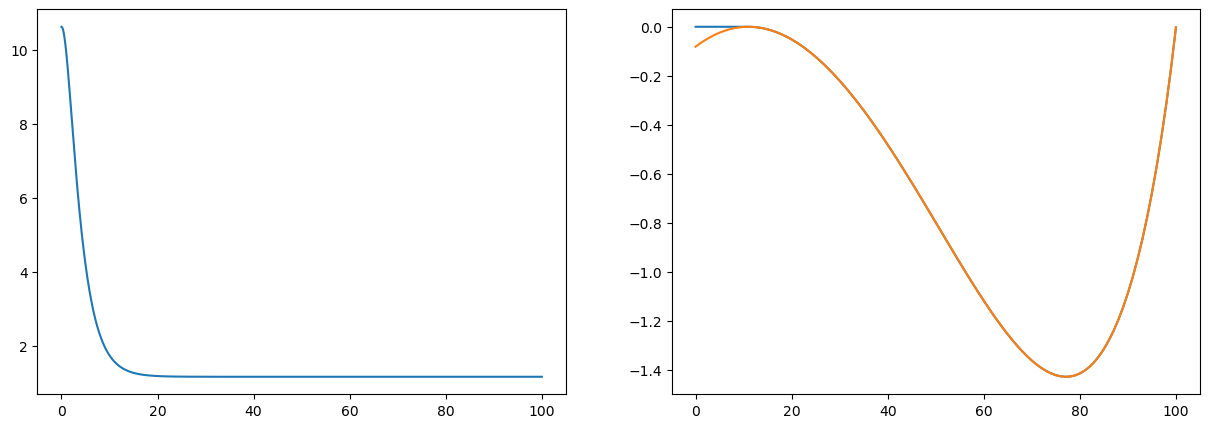

In [17]:
print(foo[0]/100, mcov[0][1][-1] - foo[1][0])
[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)
subfig_s[0,0].plot(mcov[0][0],mcov[0][1])
subfig_s[0,1].plot(mcov[1][0])
subfig_s[0,1].plot(mcov[1][1])

0.073115475 0.0


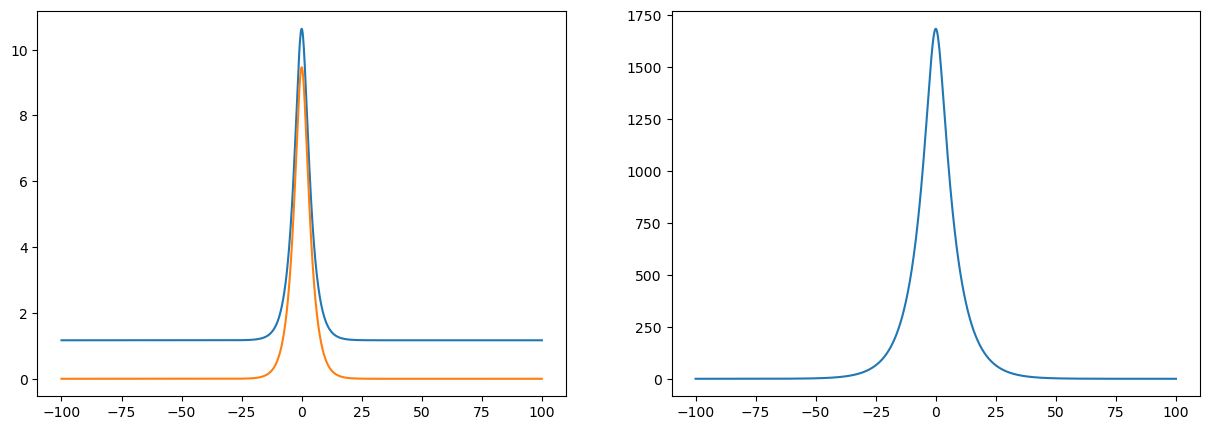

In [18]:
[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)
subfig_s[0,0].plot(allcovs[0][0], allcovs[0][1])
subfig_s[0,0].plot(allcovs[0][0], allcovs[0][2])
print(mcov[0][1][-1]/4**2,allcovs[0][2][-1])
subfig_s[0,1].plot(allcovs[0][0],jnp.einsum("ii->i",allcovs[1][0]))

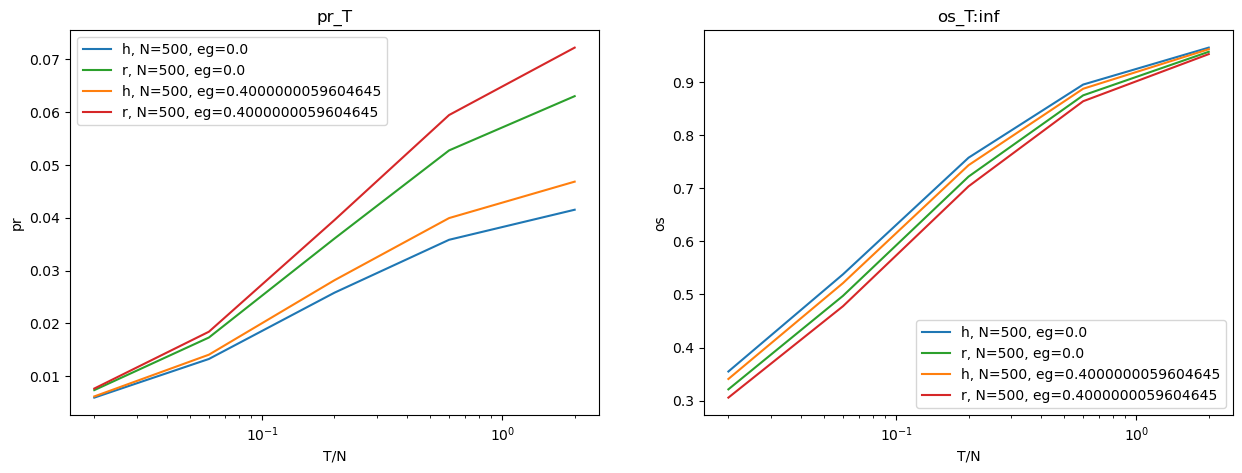

In [24]:
color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']
activity_type_s = ["h", "r"]

[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)

subfig_s[0, 0].set(title = "pr_T", xlabel = "T/N", ylabel = "pr", xscale = "log")
for extgidx in range(2):
  for activitytypeidx in range(2):
    for partnidx in range(len(partns)):
      subfig_s[0, 0].plot(windowlens / partns[partnidx], 
                          predictions[extgidx][activitytypeidx][0][partnidx, :, 0], 
                          color = color_s[activitytypeidx * 2 + extgidx], 
                          label = "{0}, N={1}, eg={2}".format(activity_type_s[activitytypeidx], partns[partnidx], extgs[extgidx]))
subfig_s[0, 0].legend()

subfig_s[0, 1].set(title = "os_T:inf", xlabel = "T/N", ylabel = "os", xscale = "log")
for extgidx in range(2):
  for activitytypeidx in range(2):
    for partnidx in range(len(partns)):
      subfig_s[0, 1].plot(windowlens / partns[partnidx], 
                          predictions[extgidx][activitytypeidx][2][partnidx, :, 0], 
                          color = color_s[activitytypeidx * 2 + extgidx], 
                          label = "{0}, N={1}, eg={2}".format(activity_type_s[activitytypeidx], partns[partnidx], extgs[extgidx]))
subfig_s[0, 1].legend()


better plots

38.24197316169739


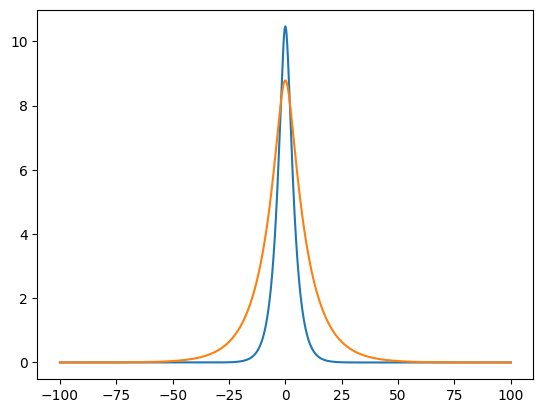

In [37]:
start_time = time.time()

h_acov = h_acov_fct(stable_h_var_fct(4)[0], 4)[0]

all_cov_s = all_cov_s_fct(h_acov, 4)

relative_lag_s = jnp.arange(32) * 10
part_n_s = jnp.array([250, 500, 1000])
window_len_s = jnp.array([10, 20, 40, 80, 160, 320, 640, 1280, 2560])
prediction_s = prediction_s_fct(all_cov_s, relative_lag_s, window_len_s, part_n_s)

end_time = time.time()
print(end_time - start_time)

plt.plot(all_cov_s[0][0], all_cov_s[0][1])
plt.plot(all_cov_s[0][0],jnp.einsum("ii->i",all_cov_s[1][1]))

plot

In [38]:
color_s = plt.rcParams['axes.prop_cycle'].by_key()['color']
activity_type_s = ["h", "r"]

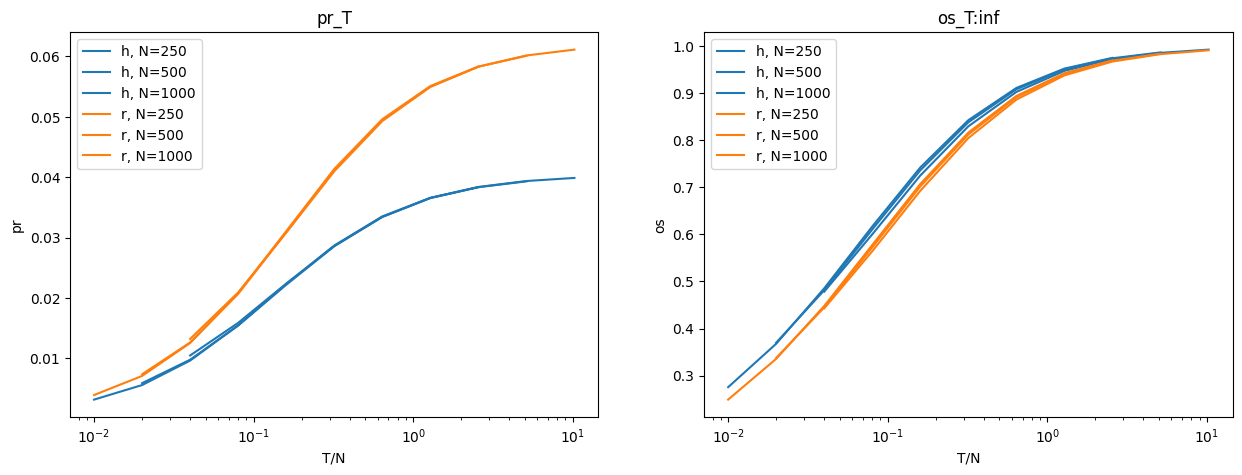

In [39]:
[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)

subfig_s[0, 0].set(title = "pr_T", xlabel = "T/N", ylabel = "pr", xscale = "log")
for activity_type_idx in range(2):
  for part_n_idx in range(len(part_n_s)):
    subfig_s[0, 0].plot(window_len_s / part_n_s[part_n_idx], 
                        prediction_s[activity_type_idx][0][part_n_idx, :, 0], 
                        color = color_s[activity_type_idx], 
                        label = "{0}, N={1}".format(activity_type_s[activity_type_idx], part_n_s[part_n_idx]))
subfig_s[0, 0].legend()

subfig_s[0, 1].set(title = "os_T:inf", xlabel = "T/N", ylabel = "os", xscale = "log")
for activity_type_idx in range(2):
  for part_n_idx in range(len(part_n_s)):
    subfig_s[0, 1].plot(window_len_s / part_n_s[part_n_idx], 
                        prediction_s[activity_type_idx][2][part_n_idx, :, 0], 
                        color = color_s[activity_type_idx], 
                        label = "{0}, N={1}".format(activity_type_s[activity_type_idx], part_n_s[part_n_idx]))
subfig_s[0, 1].legend()

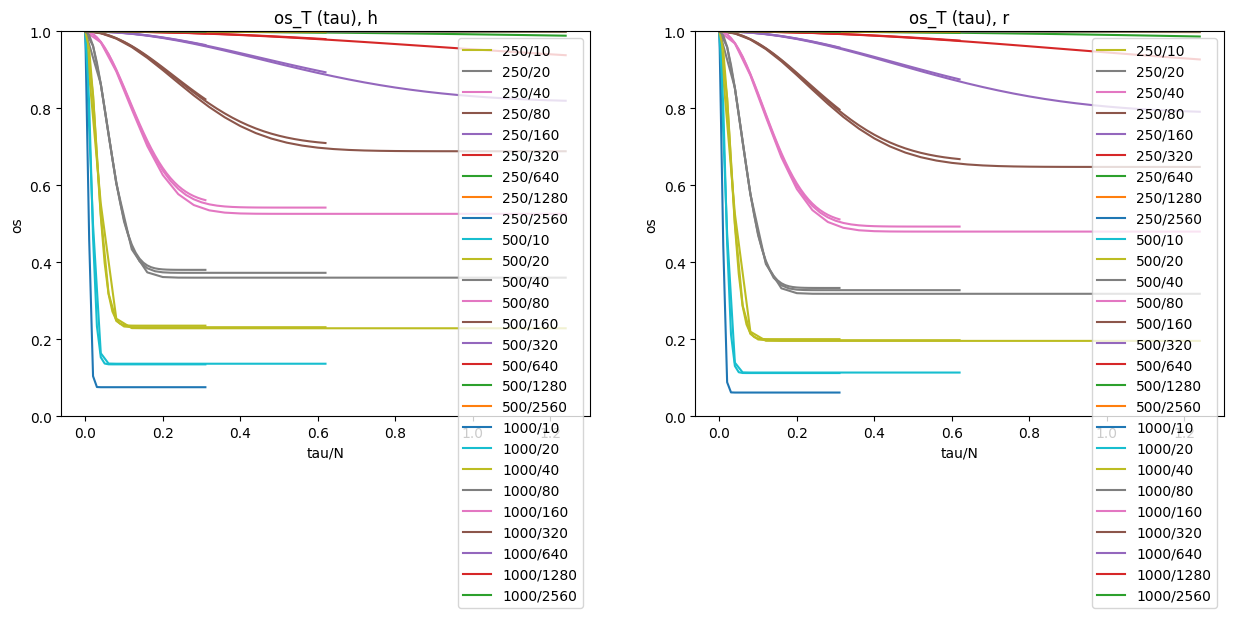

In [40]:
legend_type_s = jnp.sort(jnp.unique(part_n_s / jnp.expand_dims(window_len_s, 1)))

[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)

for activity_type_idx in range(2):
  subfig_s[0, activity_type_idx].set(title = "os_T (tau), {}".format(activity_type_s[activity_type_idx]), 
                                     xlabel = "tau/N", ylabel = "os", ylim = (0,1))
  for part_n_idx in range(len(part_n_s)):
    for window_len_idx in range(len(window_len_s)):
      subfig_s[0, activity_type_idx
      ].plot(relative_lag_s / part_n_s[part_n_idx], 
             prediction_s[activity_type_idx][1][part_n_idx, window_len_idx, :], 
             color = color_s[jnp.searchsorted(legend_type_s, 
                                              part_n_s[part_n_idx] / window_len_s[window_len_idx]) % len(color_s)], 
             label = "{0}/{1}".format(part_n_s[part_n_idx], window_len_s[window_len_idx]))
  subfig_s[0, activity_type_idx].legend()

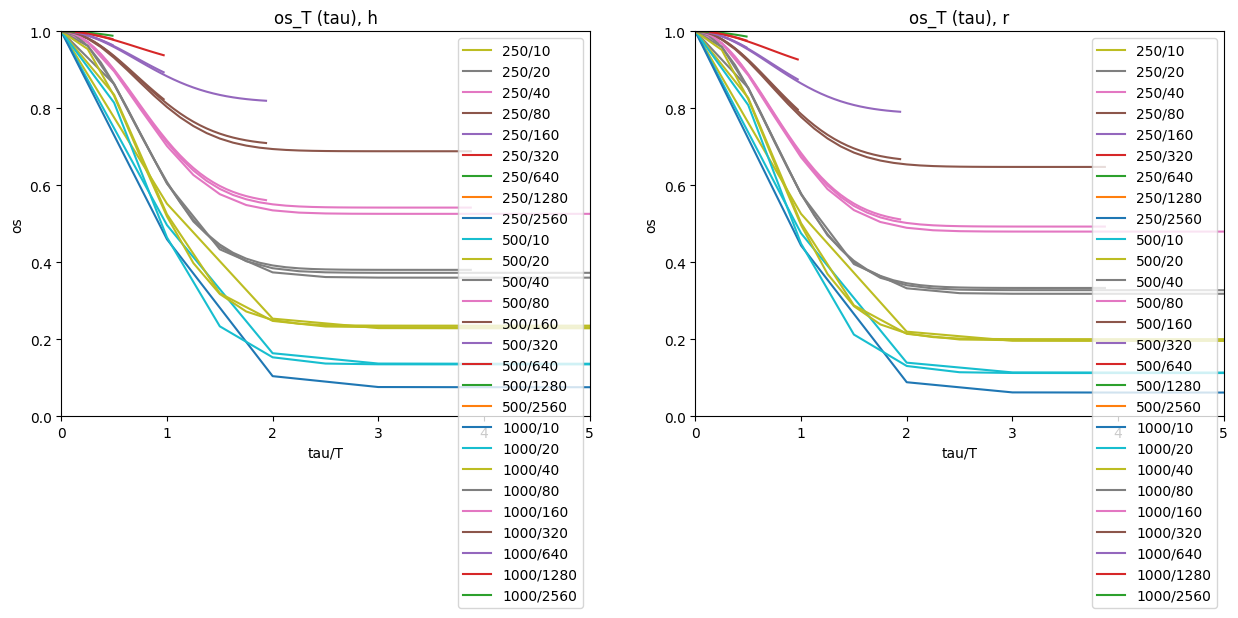

In [41]:
legend_type_s = jnp.sort(jnp.unique(part_n_s / jnp.expand_dims(window_len_s, 1)))

[fig, subfig_s] = plt.subplots(1, 2, figsize = (15,5), squeeze = False)

for activity_type_idx in range(2):
  subfig_s[0, activity_type_idx].set(title = "os_T (tau), {}".format(activity_type_s[activity_type_idx]), 
                                     xlabel = "tau/T", ylabel = "os", ylim = (0,1))
  for part_n_idx in range(len(part_n_s)):
    for window_len_idx in range(len(window_len_s)):
      subfig_s[0, activity_type_idx
      ].plot(relative_lag_s / window_len_s[window_len_idx], 
             prediction_s[activity_type_idx][1][part_n_idx, window_len_idx, :], 
             color = color_s[jnp.searchsorted(legend_type_s, 
                                              part_n_s[part_n_idx] / window_len_s[window_len_idx]) % len(color_s)], 
             label = "{0}/{1}".format(part_n_s[part_n_idx], window_len_s[window_len_idx]))
  subfig_s[0, activity_type_idx].legend()
  subfig_s[0, activity_type_idx].set_xlim(0, 5)

compare

In [42]:
#compare
[plot_window_len_s, samp_sep_s, pr_s_free, tr_s_free, os_s_free, lagged_os_free] = load_as_list("predic_free.npz")
num_r_pr_s_mean_std = jnp.array([jnp.mean(pr_s_free, axis = (0,1,2,3,4,6)),
                                 jnp.std(pr_s_free, axis = (0,1,2,3,4,6))])
num_r_tr_s_mean_std = jnp.array([jnp.mean(tr_s_free, axis = (0,1,2,3,4,6)),
                                 jnp.std(tr_s_free, axis = (0,1,2,3,4,6))])
num_r_os_s_mean_std = jnp.array([jnp.mean(os_s_free, axis = (0,1,2,3,4,6)),
                                 jnp.std(os_s_free, axis = (0,1,2,3,4,6))])
num_r_lagged_os_s_mean_std = jnp.array([jnp.mean(lagged_os_free, axis = (0,1,2,3,4)),
                                          jnp.std(lagged_os_free, axis = (0,1,2,3,4))])

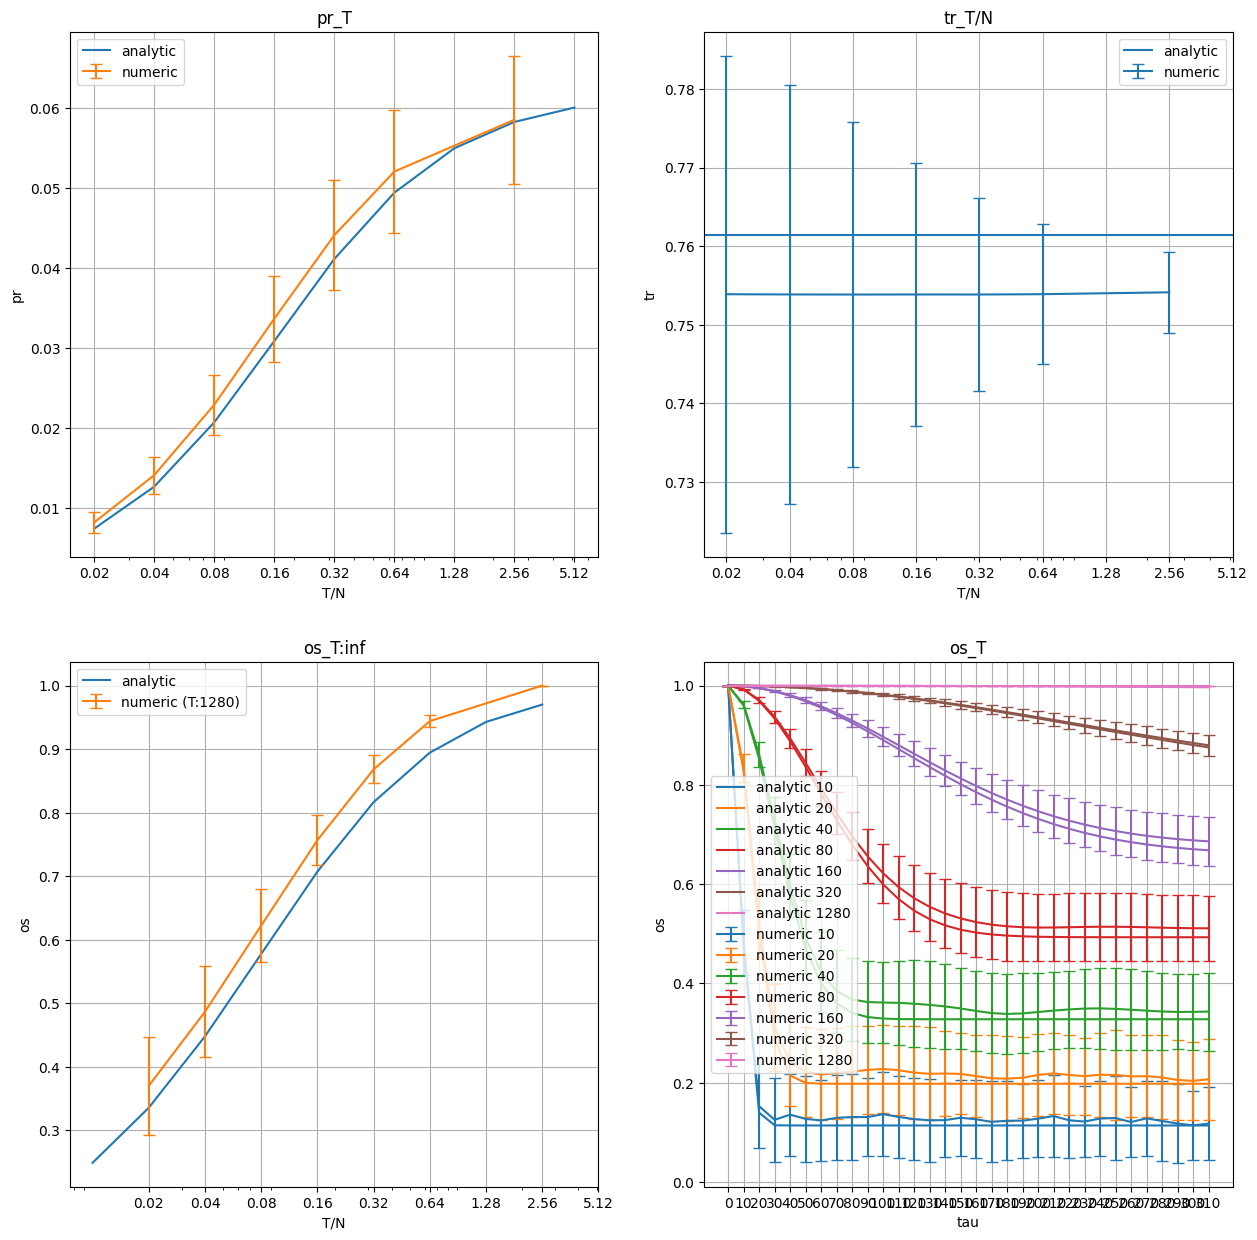

In [43]:
[fig, subfig_s] = plt.subplots(2,2, figsize = (15,15), squeeze = False)
subfig_s[0, 0].set(title = "pr_T", xlabel = "T/N", ylabel = "pr", xscale = "log")
subfig_s[0, 0].plot(window_len_s / part_n_s[1], prediction_s[1][0][1, :, 0], label = "analytic")
subfig_s[0, 0].errorbar(plot_window_len_s  / part_n_s[1], num_r_pr_s_mean_std[0], 
                        yerr=num_r_pr_s_mean_std[1], capsize = 4, label = "numeric")
subfig_s[0, 0].set_xticks(window_len_s / part_n_s[1], labels = window_len_s / part_n_s[1])

subfig_s[0, 1].set(title = "tr_T/N", xlabel = "T/N", ylabel = "tr", xscale = "log")
subfig_s[0, 1].axhline(y = jnp.max(all_cov_s[0][2]), label = "analytic")
subfig_s[0, 1].errorbar(plot_window_len_s / part_n_s[1], num_r_tr_s_mean_std[0], 
                        yerr=num_r_tr_s_mean_std[1], capsize = 4, label = "numeric")
subfig_s[0, 1].set_xticks(window_len_s / part_n_s[1], labels = window_len_s / part_n_s[1])

subfig_s[1, 0].set(title = "os_T:inf", xlabel = "T/N", ylabel = "os", xscale = "log")
subfig_s[1, 0].plot(window_len_s / part_n_s[part_n_idx], prediction_s[1][2][part_n_idx, :, 0], label = "analytic")
subfig_s[1, 0].errorbar(plot_window_len_s / part_n_s[1], num_r_os_s_mean_std[0], 
                        yerr=num_r_os_s_mean_std[1], capsize = 4, label = "numeric (T:1280)")
subfig_s[1, 0].set_xticks(window_len_s / part_n_s[1], labels = window_len_s / part_n_s[1])

subfig_s[1, 1].set(title = "os_T", xlabel = "tau", ylabel = "os")
for window_len_idx in range(len(plot_window_len_s)):
  subfig_s[1, 1].plot(relative_lag_s, 
                      prediction_s[1][1][1, jnp.searchsorted(window_len_s, plot_window_len_s[window_len_idx]), :], 
                      label = "analytic {}".format(plot_window_len_s[window_len_idx]), 
                      color = color_s[window_len_idx])
  subfig_s[1, 1].errorbar(samp_sep_s, num_r_lagged_os_s_mean_std[0, window_len_idx], 
                          yerr = num_r_lagged_os_s_mean_std[1, window_len_idx], capsize = 4, 
                          label = "numeric {}".format(plot_window_len_s[window_len_idx]), 
                          color = color_s[window_len_idx])
subfig_s[1, 1].set_xticks(relative_lag_s, labels = relative_lag_s)

for subfig in subfig_s.flatten():
  subfig.grid()
  subfig.legend()

trivial PR_T

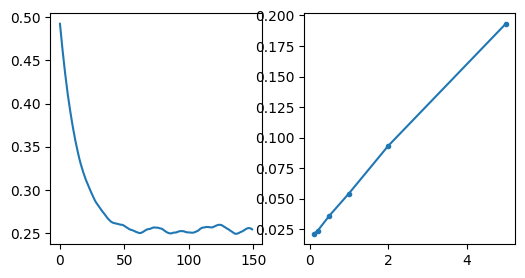

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 50
flip_n = 20
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.array([0.1, 0.2,0.5,1,2,5])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')